# 1.1 Processing Stock Price Data in Python

In [2]:
# install dependencies
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

## Q1.1.1: Plot the log-price time series of `price_data.csv`

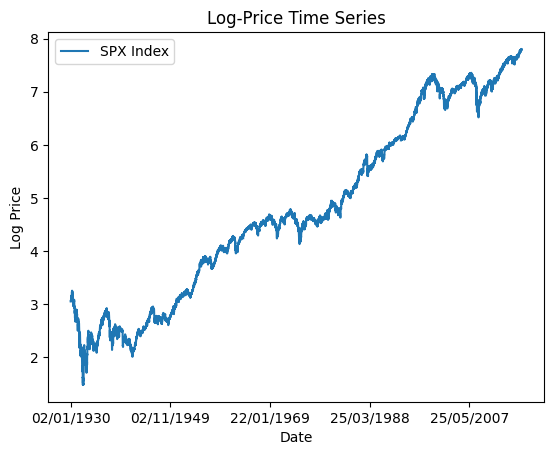

In [3]:
# load and plot price data
px = pd.read_csv("priceData.csv", index_col=0) # (index by dates not index)
logpx = np.log(px)

ax = logpx.plot(title="Log-Price Time Series")
ax.set_xlabel("Date")
ax.set_ylabel("Log Price")
plt.show()

## Q1.1.2: Plot the mean and standard deviation and comment on the stationarity of the price data.

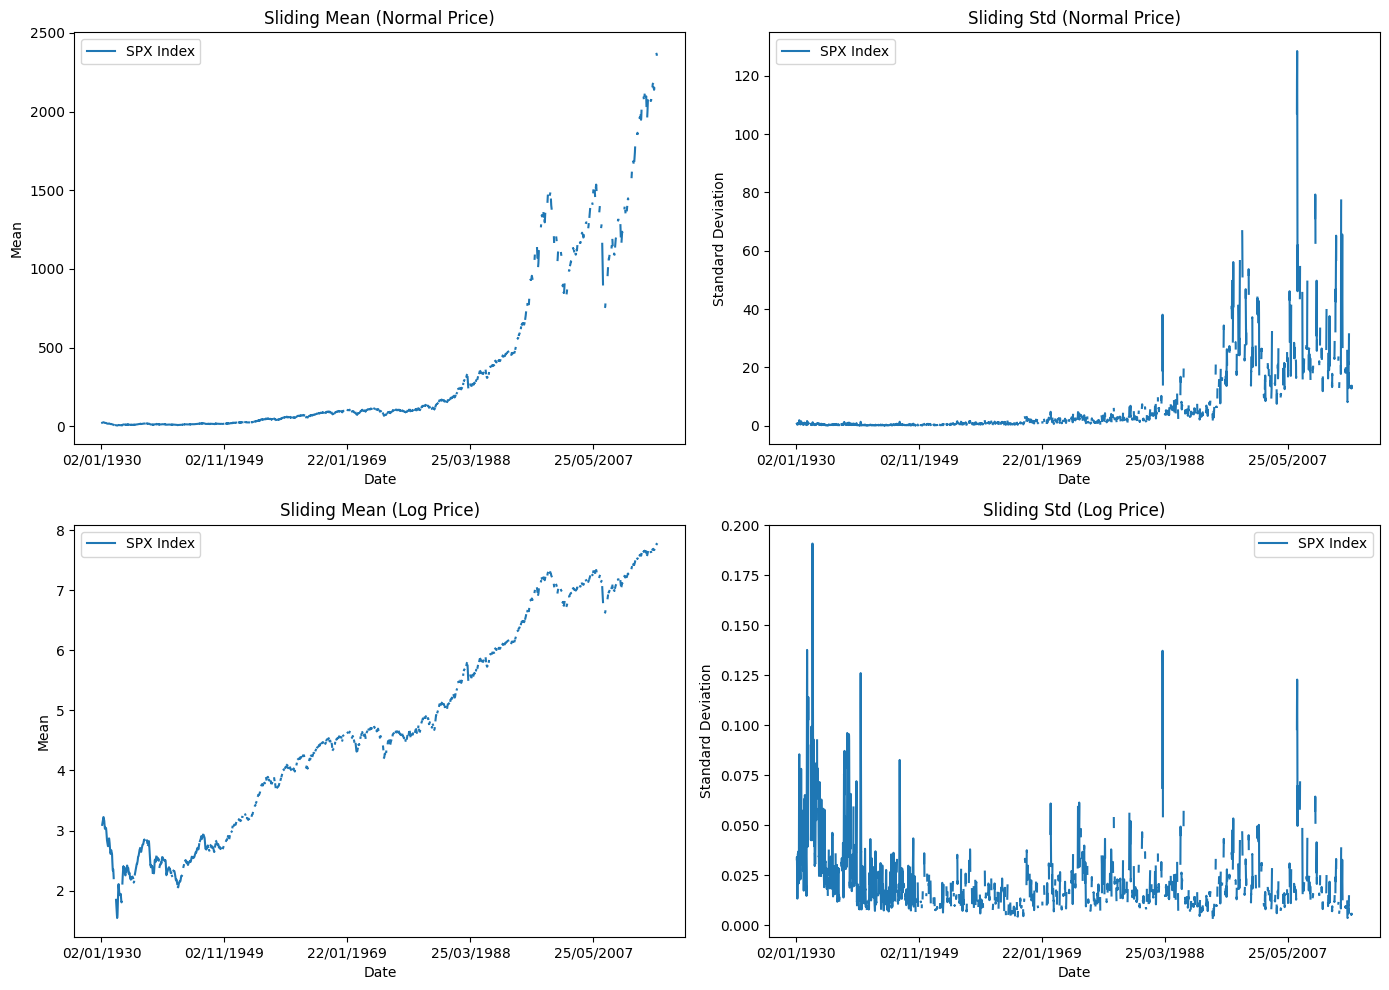

In [12]:
# TO-DO: we were told to use a sliding window of 252 days, but that doesn't really work
SLIDING_WINDOW = 30


fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# sliding mean (normal price)
px.rolling(SLIDING_WINDOW).mean().plot(ax=axes[0, 0])
axes[0, 0].set_title("Sliding Mean (Normal Price)")
axes[0, 0].set_xlabel("Date")
axes[0, 0].set_ylabel("Mean")

# sliding std (normal price)
px.rolling(SLIDING_WINDOW).std().plot(ax=axes[0, 1])
axes[0, 1].set_title("Sliding Std (Normal Price)")
axes[0, 1].set_xlabel("Date")
axes[0, 1].set_ylabel("Standard Deviation")

# sliding mean (log-price)
logpx.rolling(SLIDING_WINDOW).mean().plot(ax=axes[1, 0])
axes[1, 0].set_title("Sliding Mean (Log Price)")
axes[1, 0].set_xlabel("Date")
axes[1, 0].set_ylabel("Mean")

# sliding std (log-price)
logpx.rolling(SLIDING_WINDOW).std().plot(ax=axes[1, 1])
axes[1, 1].set_title("Sliding Std (Log Price)")
axes[1, 1].set_xlabel("Date")
axes[1, 1].set_ylabel("Standard Deviation")

plt.tight_layout()
plt.show()

These plots show that the price time series is not very stationary. Stationarity describes a series whosse statistical properties do not change over time, here we can see that both the mean and standard deviation of the price data are increasing over time.

## Q1.1.2: Compute the simple and log return time series, plot sliding window plots and comment on the stationarity of these returns.

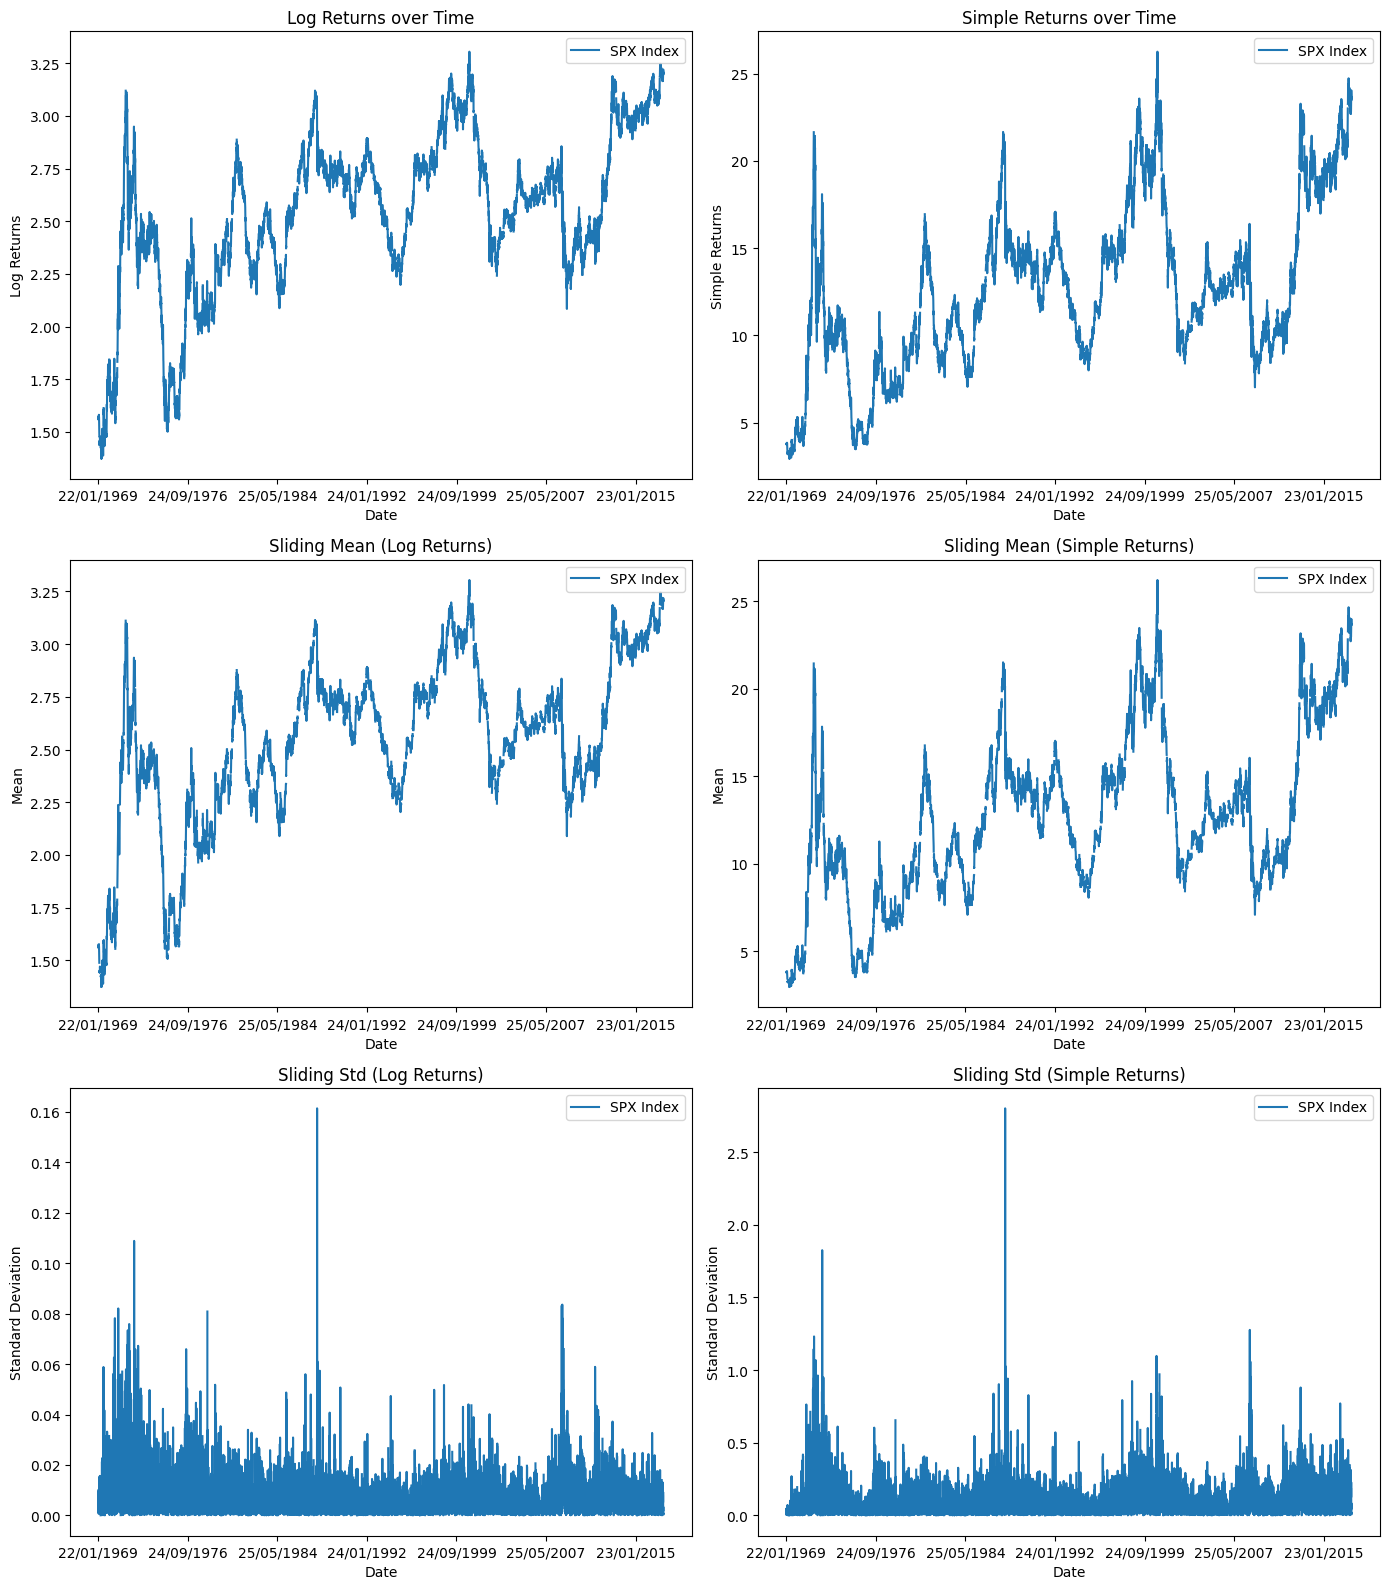

In [34]:
fig, axes = plt.subplots(3, 2, figsize=(14, 16))

SLIDING_WINDOW = 2

# increasing the diff_window supposedly increases the differences between log ret and simple ret
DIFF_WINDOW = 10000

# log return
logret = logpx.diff(DIFF_WINDOW)
logret.plot(ax=axes[0, 0])
axes[0, 0].set_title("Log Returns over Time")
axes[0, 0].set_xlabel("Date")
axes[0, 0].set_ylabel("Log Returns")

# log return mean plot
logret.rolling(SLIDING_WINDOW).mean().plot(ax=axes[1, 0])
axes[1, 0].set_title("Sliding Mean (Log Returns)")
axes[1, 0].set_xlabel("Date")
axes[1, 0].set_ylabel("Mean")

# log return std plot  
logret.rolling(SLIDING_WINDOW).std().plot(ax=axes[2, 0])
axes[2, 0].set_title("Sliding Std (Log Returns)")
axes[2, 0].set_xlabel("Date")
axes[2, 0].set_ylabel("Standard Deviation")

# simple return
simpret = px.pct_change(DIFF_WINDOW)
simpret.plot(ax=axes[0, 1])
axes[0, 1].set_title("Simple Returns over Time")
axes[0, 1].set_xlabel("Date")
axes[0, 1].set_ylabel("Simple Returns")

# simple return mean plot
simpret.rolling(SLIDING_WINDOW).mean().plot(ax=axes[1, 1])
axes[1, 1].set_title("Sliding Mean (Simple Returns)")
axes[1, 1].set_xlabel("Date")
axes[1, 1].set_ylabel("Mean")

# simple return std plot
simpret.rolling(SLIDING_WINDOW).std().plot(ax=axes[2, 1])
axes[2, 1].set_title("Sliding Std (Simple Returns)")
axes[2, 1].set_xlabel("Date")
axes[2, 1].set_ylabel("Standard Deviation")

plt.tight_layout()
plt.show()

The returns seem to be more stationary than the raw price data. The mean stays centred between 0.000 and 0.005, and although volatile, there is no trend of change in the standard deviation either.

## Q1.1.4: Justify the theoretical suitability of log returns over simple returns or signal processing. Then perform a Jaque-Bera test and comment on the results in light of the theoretical answer. 

In [36]:
# analyse the "gaussianity" of the data
logret_x = logret["SPX Index"].dropna().to_numpy()
print(f"Jaque-Bera Results for Log Returns: {stats.jarque_bera(logret_x)}")

simpret = logret["SPX Index"].dropna().to_numpy()
print(f"Jaque-Bera Results for Simple Returns: {stats.jarque_bera(simpret)}")



Jaque-Bera Results for Log Returns: SignificanceResult(statistic=np.float64(1104.9929544283964), pvalue=np.float64(1.1319537299835778e-240))
Jaque-Bera Results for Simple Returns: SignificanceResult(statistic=np.float64(1104.9929544283964), pvalue=np.float64(1.1319537299835778e-240))


Log returns are generally preferred for signal processing over simple returns for a number of reasons.

$$ r_t = \log P_t - \log P_{t-1} $$
$$ R_t = \frac{P_t - P_{t-1}}{P_{t-1}} $$

Firstly, log returns are additive over time.

$$ log P_T - \log P_0 = \sum_{t=1}^{T} r_t $$

Secondly, if proces follow a geometric Brownian motion then log returns are (more) normally distributed.

Therefore, I expected to see that log returns had a higher gaussianity than simple returns, but for some reason they are identical?


## Q1.1.5: You purchase a stock for £1. The next day its value goes up to £2 and the following day back to £1. What are the simple and logarithmic returns over this period and what can you conclude about logarithmic returns on the basis of this example?

In the case of simple returns, the returns from Day 1 to Day 2 are 100%, the next day the returns are -50%.
In the case of log returns, the returns from Day 1 to Day 2 are 0.693, the next day the returns are -0.693.

This shows us that log returns are additive, simple summing the two log returns shows us that the investment breaks even over the two days.

## Q1.1.6: Under what circumstances should you not use log returns over simple returns?

If a stock drops to zero, then the log return is not possible to determine, as log(0) is undefined.

Additionally, log returns are not suitable for very volatile assets, as they understate large gains/losses.

# 1.2: ARMA vs ARIMA Models for Financial Applications

## Q1.2.1: Plot the S&P500 time series, comment on whether an ARMA or ARIMA model would be more appropriate.

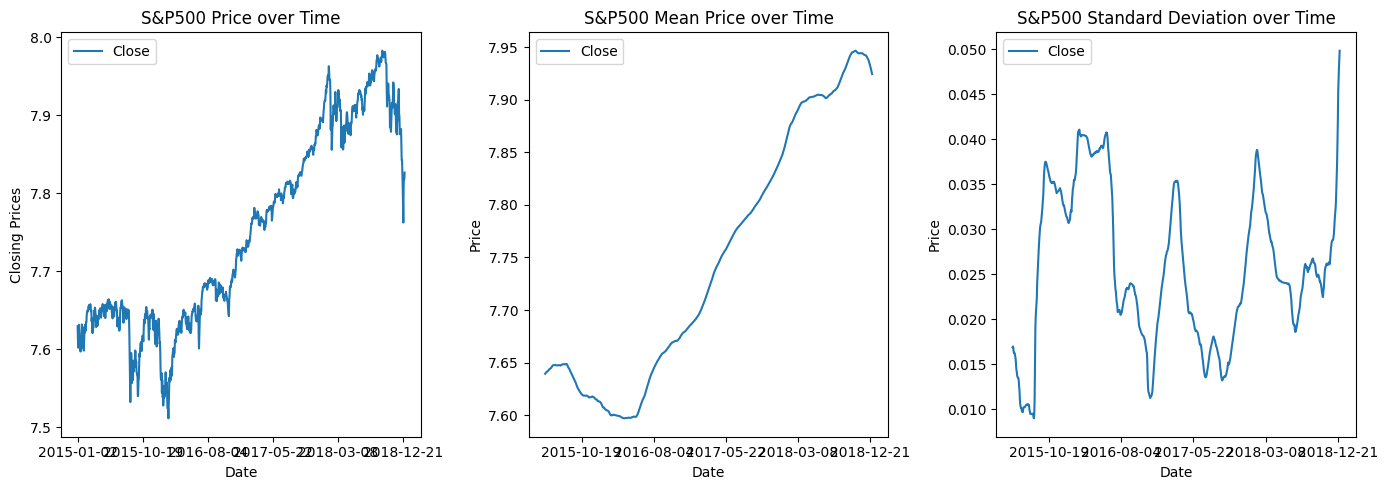

In [51]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AR
import copy

snp = pd.read_csv("snp_500_2015_2019.csv")
snp.set_index(["Date"], inplace=True)
snp_close_log = snp["Close"].to_frame().apply(np.log)

fig, axes = plt.subplots(1, 3, figsize=(14, 5))

SLIDING_WINDOW = 100

snp_close_log.plot(ax=axes[0])
axes[0].set_title("S&P500 Price over Time")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Closing Prices")

snp_close_log.rolling(SLIDING_WINDOW).mean().plot(ax=axes[1])
axes[1].set_title("S&P500 Mean Price over Time")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Price")

snp_close_log.rolling(SLIDING_WINDOW).std().plot(ax=axes[2])
axes[2].set_title("S&P500 Standard Deviation over Time")
axes[2].set_xlabel("Date")
axes[2].set_ylabel("Price")

plt.tight_layout()
plt.show()


The ARMA model assumes stationarity of the data, whereas ARIMA can handle non-stationary data. The plots above indicate that the S&P 500 price data is not stationary, as the mean is increasing, and therefore an ARIMA model would be better suited.

## Q1.2.2: Fit an ARMA(1, 0) model, plot the prediction and true signal, inspect the model parameters, comment on the results, are these findings useful in practice?

/Users/tobybrowne/Documents/Imperial College London/Year 4/MIF/Machine-Intelligence-for-Finance-CW/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tobybrowne/Documents/Imperial College London/Year 4/MIF/Machine-Intelligence-for-Finance-CW/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tobybrowne/Documents/Imperial College London/Year 4/MIF/Machine-Intelligence-for-Finance-CW/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.


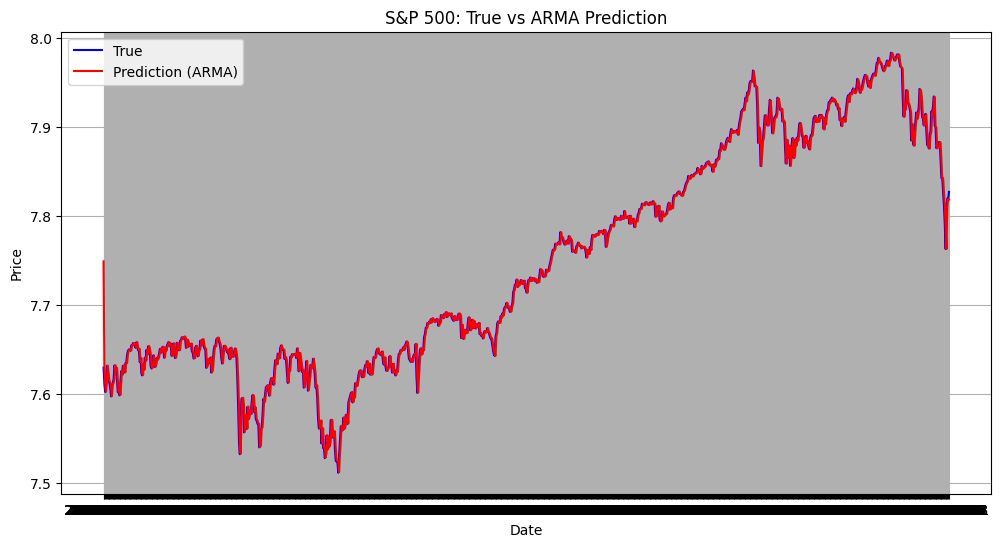

Model Parameters:
const     7.748867
ar.L1     0.997354
sigma2    0.000074
dtype: float64


In [52]:
# fit an ARMA model
snp_arma = copy.deepcopy(snp_close_log)
snp_arma.columns = ["True"]
model = ARIMA(snp_arma["True"], order=(1,0,0)).fit()
snp_arma["Res"] = model.resid
snp_arma["Prediction"] = snp_arma["True"] - snp_arma["Res"]

# plot True vs Predicted ARMA model
plt.figure(figsize=(12,6))
plt.plot(snp_arma.index, snp_arma["True"], label="True", color="blue")
plt.plot(snp_arma.index, snp_arma["Prediction"], label="Prediction (ARMA)", color="red")
plt.title("S&P 500: True vs ARMA Prediction")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

# print model params
print("Model Parameters:")
print(model.params)


The `const` term is just the offset of the signal (intercept with the y-axis).

The `L1` term is the autogregressive coefficient, it tells us how related each days price is to the day before - here we can see that it is very high, indicating that the S&P500 is very persistent day-to-day.

The `sigma2` term is the variance of the model's error term, it is very small telling is that day-to-day there a very few sudden shocks, most of the day's value is just determined by the value the day before.

This model doesn't really do anything useful, besides explaain some day-to-day properties of the S&P, it has no predictive ability as it is not determining any trends.


## Q1.2.3: Fit an ARIMA(1, 1, 0) model and compare with the ARMA(1, 0) model, which analysis is more physically meaningful?

/Users/tobybrowne/Documents/Imperial College London/Year 4/MIF/Machine-Intelligence-for-Finance-CW/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tobybrowne/Documents/Imperial College London/Year 4/MIF/Machine-Intelligence-for-Finance-CW/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tobybrowne/Documents/Imperial College London/Year 4/MIF/Machine-Intelligence-for-Finance-CW/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.


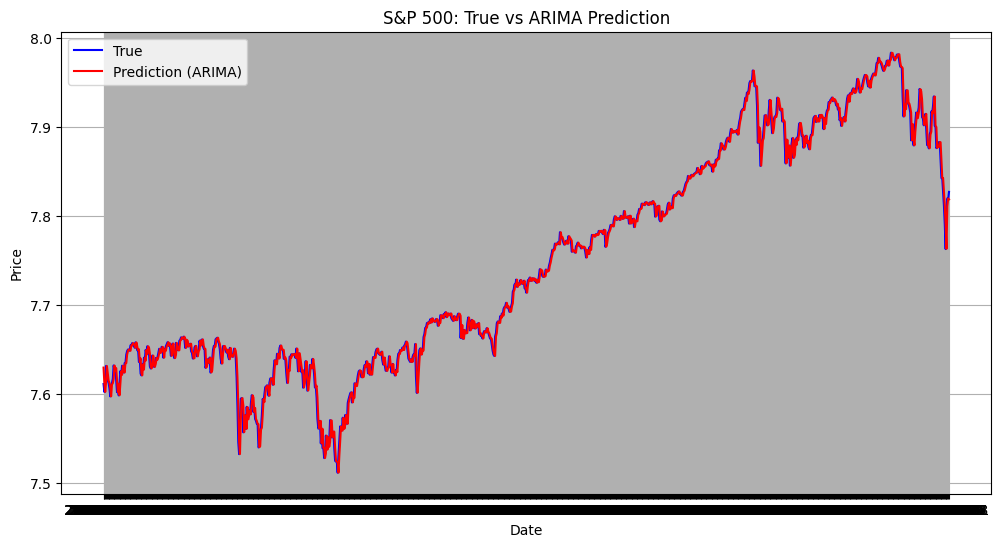

Model Parameters:
ar.L1    -0.008170
sigma2    0.000074
dtype: float64


In [53]:
# fit an ARMA model
snp_arma = copy.deepcopy(snp_close_log)
snp_arma.columns = ["True"]
model = ARIMA(snp_arma["True"], order=(1,1,0)).fit()
snp_arma["Res"] = model.resid
snp_arma["Prediction"] = snp_arma["True"] - snp_arma["Res"]
snp_arma = snp_arma[snp_arma["Prediction"] != 0]

# plot True vs Predicted ARMA model
plt.figure(figsize=(12,6))
plt.plot(snp_arma.index, snp_arma["True"], label="True", color="blue")
plt.plot(snp_arma.index, snp_arma["Prediction"], label="Prediction (ARIMA)", color="red")
plt.title("S&P 500: True vs ARIMA Prediction")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

# print model params
print("Model Parameters:")
print(model.params)


The ARIMA(1,1,0) applies the first difference between the price data day-on-day, meaning that it is then essentially applying an ARMA(1,0) model on the S&P 500's log returns.
The log returns are basically random day-on-day, which is suppported by the almost zero autoregressive term.

## Q1.2.4: Comment on the necessity of taking the log of the prices for the ARIMA analysis.

Whilst the differencing component of ARIMA can remove non stationarity caused by an increasing mean, it cannot handle non-stationarity due to an increasing standard deviation.
The log transform converts multiplicative changes into additive changes, making the series' variance more stationary.

# 1.3: Vector Autoregressive (VAR) Models

### Q1.3.4: Consider stocks CAG, MAR, LIN, HCP, MAT and detred them using an MA(66) model. Then fit a VAR(1) model and compute the eigenvalues of the regression matrix A. Would it make sense to construct a portfolio using these stocks?

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.api import VAR

df = pd.read_csv("snp_allstocks_2015_2019.csv")
df = df.set_index("Date")

info = pd.read_csv("snp_info.csv")
info.drop(columns=info.columns[0], inplace=True)

# detrend the stock by subtracting the moving average from each stock (independently)
tickers = ["CAG", "MAR", "LIN", "HCP", "MAT"]
stocks = df[tickers]  
stocks_ma = stocks.rolling(window=66).mean()
stocks_detrended = stocks.sub(stocks_ma).dropna() # stocks - stocks_ma

# fit VAR(1) model
model = VAR(stocks_detrended)
results = model.fit(1)
A = results.params[1:].values
eigA, _ = np.linalg.eig(A)

print(f"Portfolio Eigenvalues:")
for eigenvalue in eigA:
    print(np.abs(eigenvalue))   



Portfolio Eigenvalues:
0.7260939285436439
0.7260939285436439
1.0063596404610204
0.8605189429713626
0.9114451152082141


/Users/tobybrowne/Documents/Imperial College London/Year 4/MIF/Machine-Intelligence-for-Finance-CW/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


We determined earlier that the regression matrix should have eigenvalues of less than 1 for the system to be stable. In this portfolio, one of the eigenvalues equals 1, meaning that shocks to the portfolio won't dampen out, instead they will persist, making this an unstable portfolio.

### Q1.3.5: Repeat the previous task but forming portfolios grouped by stock sector, is this more advisable?

In [63]:
stable_portfolios = 0
unstable_portfolios = 0
portfolio_size = []

for sector in info["GICS Sector"].unique():
    sector_tickers = info.loc[info["GICS Sector"] == sector, "Symbol"].tolist()
    sector_stocks = df[sector_tickers]
    portfolio_size.append(len(sector_tickers))
    sector_stocks_ma = sector_stocks.rolling(window=66).mean()
    sector_stocks_detrended = sector_stocks.sub(sector_stocks_ma).dropna()

    model = VAR(sector_stocks_detrended)
    results = model.fit(1)
    A = results.params[1:].values
    eigA, _ = np.linalg.eig(A)

    print(f"\nSector: {sector}")
    # check if any eigenvalues have magnitude >= 1
    unstable = np.any(np.abs(eigA) >= 1)
    if unstable:
        print("The portfolio is unstable, it would not make sense to construct a portfolio using these stocks.")
        unstable_portfolios += 1
    else:
        print("The portfolio is stable, it may make sense to construct a portfolio using these stocks.")
        stable_portfolios += 1
    print("")

print(f"Total Stable Portfolios: {stable_portfolios}")
print(f"Total Unstable Portfolios: {unstable_portfolios}")
print(f"Average Portfolio Size: {np.mean(portfolio_size)}")



Sector: Industrials
The portfolio is stable, it may make sense to construct a portfolio using these stocks.


Sector: Health Care
The portfolio is stable, it may make sense to construct a portfolio using these stocks.


Sector: Information Technology
The portfolio is stable, it may make sense to construct a portfolio using these stocks.


Sector: Communication Services
The portfolio is stable, it may make sense to construct a portfolio using these stocks.


Sector: Consumer Discretionary
The portfolio is stable, it may make sense to construct a portfolio using these stocks.


Sector: Utilities
The portfolio is stable, it may make sense to construct a portfolio using these stocks.


Sector: Financials
The portfolio is unstable, it would not make sense to construct a portfolio using these stocks.


Sector: Materials
The portfolio is stable, it may make sense to construct a portfolio using these stocks.


Sector: Real Estate
The portfolio is stable, it may make sense to construct a portf

/Users/tobybrowne/Documents/Imperial College London/Year 4/MIF/Machine-Intelligence-for-Finance-CW/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tobybrowne/Documents/Imperial College London/Year 4/MIF/Machine-Intelligence-for-Finance-CW/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tobybrowne/Documents/Imperial College London/Year 4/MIF/Machine-Intelligence-for-Finance-CW/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.


If all 11 sectors in this dataset are used to form 11 portfolios divided by sector type then 10 of them will be stable and only 1 will be unstable.
This doesn't necessarily mean that this is a good investment strategy, it could leave investors vulnerable to disruptions in a given sector, however each of these portfolios has on average 45 stocks, which in itself, likely makes these portfolios more stable than those seen in Q1.3.5